

## <span style="color:#4375c7">DAI</span>
***
*Course materials are for educational purposes only. Nothing contained herein should be considered investment advice or an opinion regarding the suitability of any security. For more information about this course, please contact us.*
***

### Session contents:
1. **[Deep Learning - Generative models ](#NN)**
    - [Variational autoencoder](#VAE)
    - [Generative adversarial network](#GAN)

    
2. **[Hands-on session](#ho)**
***

##  Deep Learning - Generative models <a name="NN"></a> 

**Generative models** can be used to learn the underlying distribution of a data set. With the distribution, we can sample from a latent space of data to create entirely new artificial data. There are various applications for artificial data and generative models, such as generating photographs of human faces or animals, cartoon characters, text to image translation, photos to emojis, clothing translation, music, or time series generation [5].

The basic concept of generative models is to create a low-dimensional latent space of representations where each point is mapped to a realistic data point such as an image, time series, or text. To map the latent space to a realistic output, we use neural networks. These mapping networks are also called generators or decoders, as we will see later. After developing the latent space, we can randomly sample points from it and map them to our output to get new artificial data [4]. *(The figure below is taken from Chollet [4])* 

<img src="../assets/data_generation.png" alt="Drawing" style="width: 550px;"/>



We will focus on two generative deep learning models, the generative adversarial network (GAN) and the variational autoencoder (VAE). Both use different strategies to generate new data. While VAEs can easily learn structured latent spaces where different directions encode a meaningful axis of variation in the data, GANs can generate more realistic artificial data but use latent spaces that are less structured [4].

During this course, we will use **[keras](https://keras.io/)** for the analysis. Keras is one of the most widely used Python libraries for solving machine learning problems with deep neural networks.
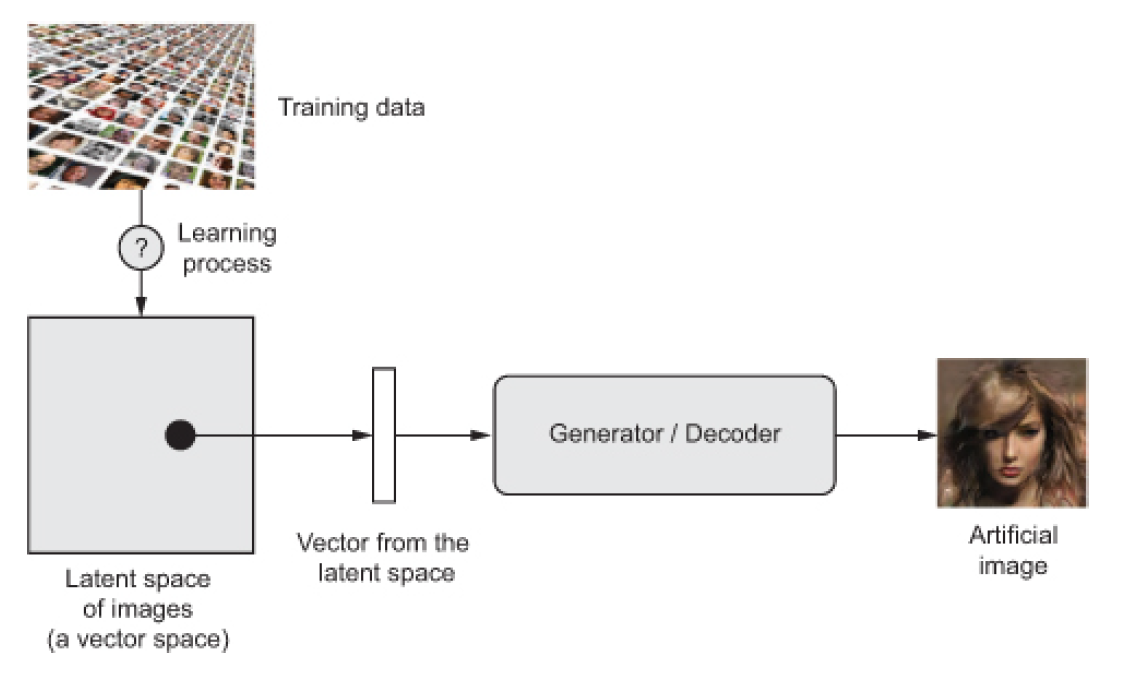

### Variational autoencoders <a id='VAE'></a>

The **Variational Autoencoder** (VAE) was introduced by  Kingma & Welling [6] and Rezende et al. [7]. 

A VAE is an extended model of an **autoencoder**. An autoencoder encodes or compresses the input to a fixed code in the **latent space** and decodes it back to the same image. *(The figure below is taken from Chollet [4])* 

<img src="../assets/autoencoder.png" alt="Drawing" style="width: 550px;"/>



Unlike an autoencoder, the VAE encodes the input data into parameters of a statistical distribution. It assumes that the data was generated by a statistical process. After encoding the data into the mean and variance of that distribution, the VAE randomly samples a point from the distribution. This random point is then decoded back to the original input. 

The stochastic random part of this encoding and decoding process forces the latent space to encode meaningful representations. Each point sampled from the latent space is decoded into an original output [4]. *(The figure below is taken from Chollet [4])* 

<img src="../assets/vae.png" alt="Drawing" style="width: 550px;"/>


Basically, a VAE consists of a pair of two connected neural networks. One neural network, acting as an **encoder**, encodes the data into a representation in the latent space, and the other neural network, acting as an **decoder**, decodes the encoded data to obtain the original data. 

The VAE is typically trained as a single network and optimized by **back-propagation**. The number of nodes in each layer of the encoder decreases as the encoder learns to discard irrelevant information in the data. 
The number of nodes of each layer of the decoder increases as the decoder learns to reconstruct the input data from the encoding.

Let's start by building a VAE following an example from Chollet [4] for image generation of the **MNIST** handwritten digits dataset. We use layers other than dense layers, called **convolutional** layers, which are efficient and powerful layers for **image processing**. If you want to learn more about convolutional layers and more about neural networks for image data, please take the interactive **DataCamp** course "Image Processing with Keras in Python". 
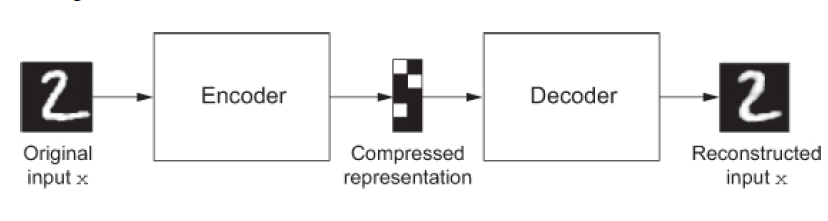
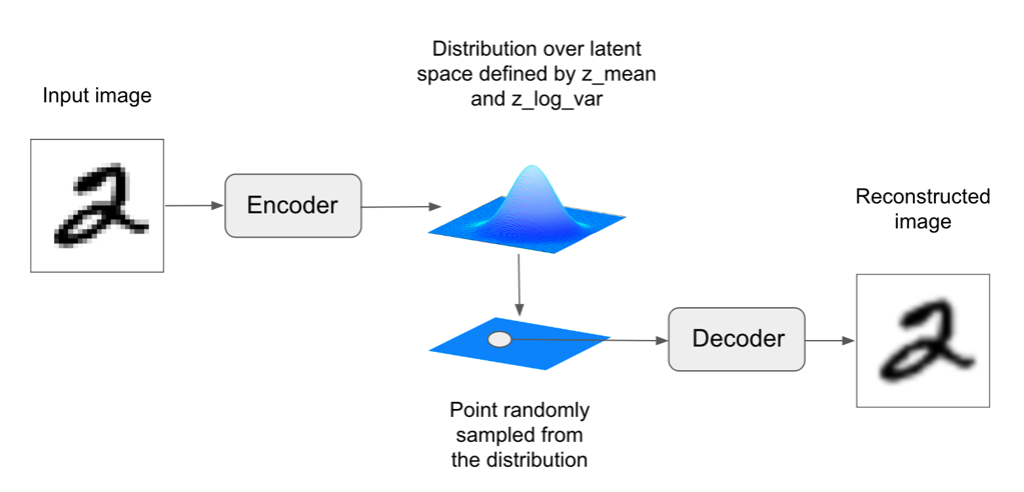

In [41]:
import keras
from keras import layers
from keras.models import Model
import numpy as np
import tensorflow as tf

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # dimension of the latent space

# Build the encoder:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = x.shape[1:]  # get the shape of the data after convolution

x = layers.Flatten()(x)  # convert images to flatten vector that you could pass to a Dense layer
x = layers.Dense(32, activation='relu')(x)

# Parameters of the latent space
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling from the latent space also called reparametrization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(keras.backend.shape(z_mean)[0], latent_dim),
                                          mean=0., stddev=1.)
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z])

# Build the decoder:

# Input of the decoder (z).
decoder_input = layers.Input(shape=(latent_dim,))

# Upsample to the correct number of nodes
x = layers.Dense(np.prod(shape_before_flattening),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before flattening the images in the encoder
x = layers.Reshape(shape_before_flattening)(x)

# Conv2DTranspose layers do the reverse operation to the convolutional layers:
x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

# We receive a feature map of the same size as the input
decoder = Model(decoder_input, x)

# We apply the decoder model to z of the latent space to receive the decoded z
z_decoded = decoder(encoder(input_img)[2])


The training procedure can be described as follows:

Given an input dataset, the encoder encodes the data points into a mean $\mu$ and a variance $\sigma$ parameter of a distribution in the latent space. Then, we generate a random data point 

$$ z= \mu + \sigma*\epsilon $$

from the latent distribution with $\epsilon \sim \mathcal{N}(0,I)$, a random standard normal distributed tensor, and decode that point to the original input data. By multiplying with $\epsilon$, we can verify that each point close to $z$ can be decoded to an output that is similar to the input data.

We minimize the mean of two loss functions: A **reconstruction loss** function that forces the decoded samples to be similar to the input data, and a **regularization loss** function that prevents the autoencoder from overfitting and helps to learn the latent space.

We use the **binary cross entropy** as the reconstruction loss function, while we use **Kullback–Leibler divergence** as the regularization loss function.
To generate a new sample with a VAE, we select a random point of the learned latent distribution and decode it with the decoder. 


In [42]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.

#Instead of defining a loss function we use a trick: a custom last layer that works as loss function
#y = CustomVariationalLayer()([input_img, z_decoded])

#build the vae model in keras and print the summary
#vae = Model(input_img, y)
vae = Model(input_img, z_decoded)
vae.compile(optimizer='rmsprop', loss=None)
encoder.summary()
decoder.summary()

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_25[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 14, 14,    │     18,496 │ conv2d_63[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_64[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_65[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 12544)     │          0 │ conv2d_66[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │    401,440 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 2)         │         66 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 2)         │         66 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 2)         │          0 │ dense_39[0][0],   │
│                     │                   │            │ dense_40[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 14, 14, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,241 (508.75 KB)

 Trainable params: 130,241 (508.75 KB)

 Non-trainable params: 0 (0.00 B)

Let's read in the data and fit the VAE model. Fitting a VAE can be very costly in terms of computing power and time. Please use a GPU processor if available. 

In [47]:
from keras.datasets import mnist

# Train the vae model on MNIST handwritten digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/10


AttributeError: Exception encountered when calling Lambda.call().

[1mmodule 'keras.backend' has no attribute 'shape'[0m

Arguments received by Lambda.call():
  • inputs=['tf.Tensor(shape=(16, 2), dtype=float32)', 'tf.Tensor(shape=(16, 2), dtype=float32)']
  • mask=['None', 'None']
  • training=True

After fitting our model, we want to generate images from the structured latent space and plot them in a grid of 10 decoded images. 

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm


n = 10  # number of digits we want to plot
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian [4]
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

#plot a grid from decoded images from the latent space
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

We receive a grid of the sampled images, which provides us with a continuous distribution of the digit classes of the data set. You can even follow the paths through the latent space, following the grid axis of morphing digits [4].

### Generative adversarial  networks <a id='GAN'></a>

A **generative adversarial network** (GAN) is a generative model introduced by Goodfellow et al. [8], where two neural networks are trained simultaneously.
The first network is called the **generator** G, which takes a random point of the **latent space** as an input and captures the true distribution of the data. The second network is the **discriminator** D, which estimates the probability that a sample came from the real data instead of the synthetic data produced by G. 

The training process can be stated as follows:

G and D play a **two-player minimax game** against each other to optimize the model. Therefore, the training procedure of G is basically maximizing the probability that D is making a failure. G learns to capture any implicit distribution from a training data set and provides a way to draw samples from that distribution. Simultaneously, we train D to maximize the probability of assigning the correct label to training examples and samples from G.

Let $x \sim \mathcal{D}$ be our given data set. We assume some prior distribution $z \sim p_z(z)$ that G should learn such that $G(z)\sim p_{data}(x)$. Let $V(G,D)$ be our value function. We then want G and D to play the following minimax game:

\begin{equation}
\min_G \max_D V(G,D) = \mathbb{E}_{x \sim p_{data}(x)} [log D(x)] + \mathbb{E}_{z \sim p_{z}(z)} [log(1-D(G(z))]
\end{equation}

To simulate new samples from G, we calculate random normal data points $z$ from the latent space and use the trained generator function $G(z)$ to generate a new sample $x$  [8], [4]. 

Let's start to construct the GAN inspired by Chollet [4] for image generation and use it for the *kaggle* cat images data set. So, we basically use it to generate pictures of cats.

We start with the **generator**. The generator model transforms a random vector from the latent space to an artificial data point. 


In [ ]:
import keras
from keras import layers
import numpy as np


latent_dim = 64
height = 64
width = 64
channels = 1

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 5, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 5, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()



The **discriminator** takes the candidate data point (real or fake)  as an input and classifies it. So it decides whether it is a generated data point or a point from the training set. 

We use the **sigmoid activation** function in the last layer as the discriminator performs a **binary classification** task [4].

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008, clipvalue=1.0)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

The final GAN model chains the generator and the discriminator together: GAN(x) = D(G(x)). The GAN maps the latent space vectors to the classification of the discriminator. The discriminator should be frozen during the training process of the generator as the GAN updates the weights of the generator in a way that makes the discriminator predict more likely "real" when classifying artificial data points [4].

In [ ]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
gan.summary()

Each epoch in the training process consists of the following steps:
    
    1. Draw random points from the latent space using the standard normal distribution
    2. Generate artificial data points with the generator
    3. Mix the generated data points with the real data points from the training set
    4. Unfreeze the discriminator weights
    5. Train the discriminator with the mixed data points
    6. Draw new random points from the latent space
    7. Freeze the discriminator weights
    8. Train the whole GAN with the random vectors and targets that always return true. This will update the weights of the generator in a way that the discriminator will predict generated data points as real data points.


The training of a GAN is difficult because it is a dynamic process and not just a simple gradient descent process with a fixed loss landscape. The correct training of a GAN requires an extensive tuning and adjustment of the GAN architecture [4]. *(The figure below is taken from Chollet [4])* 

<img src="../assets/GAN.png">


Let's train the GAN model on the **kaggle** cats data set.

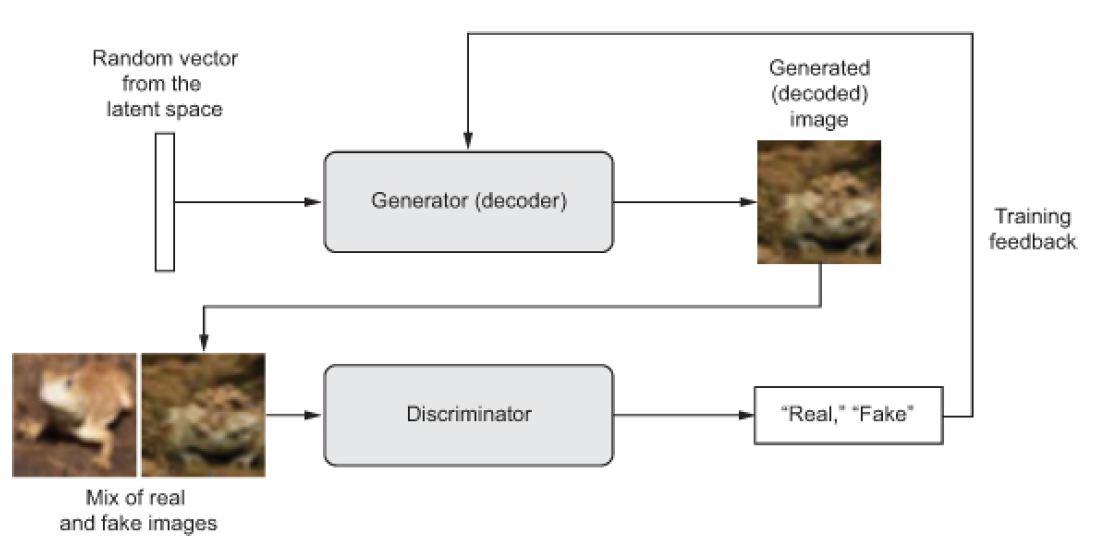

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import pickle

with open("../data/cat_dataset_64x64.pickle", "rb") as file:
    x_train = pickle.load(file)

x_train = x_train.reshape(-1,64,64,1)       
x_train = x_train / 127.5 - 1.  # values -1 to 1

iterations = 1000
batch_size = 20



# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]

    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)
    
    discriminator.trainable = True
    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    discriminator.trainable = False
    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        #img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        plt.figure()
        plt.imshow(img,cmap='gray')
        plt.show()
        
        
plt.plot(a_loss, label="Loss generator")
plt.plot(d_loss, label="loss discriminator")
plt.legend()
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

We sum up some tips following Chollet [4] for the training process of a GAN:

- Sample points from the latent space using a normal distribution

- To induce robustness use stochasticity. GANs might get stuck during the training as it results in a dynamic equilibrium. Therefore introduce randomness by using a dropout layer in the discriminator and adding random noise to the labels for the discriminator.

- Use Leaky ReLu activation functions to prevent sparse gradients during the GAN training

- Use a lower learning rate for the generator as for the discriminator

Let's plot some of the artificial cat images:

In [ ]:

import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=True)
    plt.figure()
    plt.imshow(img,cmap='gray')
    
plt.show()

<br/><br/>

### Session takeaways 

*What are the learnings of this session?*

- you know the structure and training of a variational autoencoder and  a generative adversarial network
- you know how to generate new data with a variational autoencoder and a generative adversarial network


*What's next?*

During the hands-on session, you are using Keras to build your own VAE and GAN for time series generation.

<br/><br/>

## 2. Hands-on session <a id='ho'></a>

### Exercise 1
1. Read in the day-ahead electricity data set and visualize a random set of the daily auctions. Each auction contains 24 auction prices of electricity loads, one for each hour of a day.

2. Use the given structure of a GAN to generate new time series. Complete the missing parts in the code marked with ___ . Use dense layers instead of convolutionals. Run the code and generate new time series.


### Exercise 2
1.  Read in the day-ahead electricity data set and split the data set into a test and a train data set. Do a split after four years of data. Keep leap years in mind. 

2. Use the given structure of a VAE to generate new time series. Complete the missing parts in the code marked with ___. Use dense layers instead of convolutionals. Run the code and generate new time series.
